In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import src.GBM as GBM
import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  1 of 1 completed


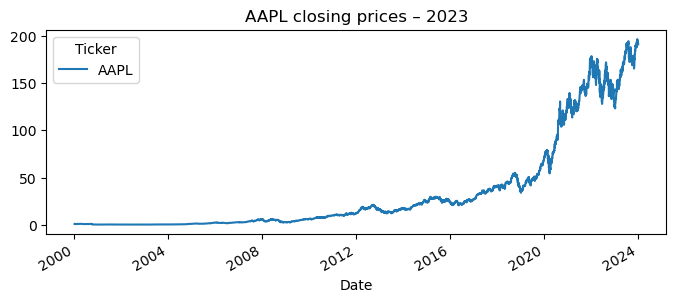

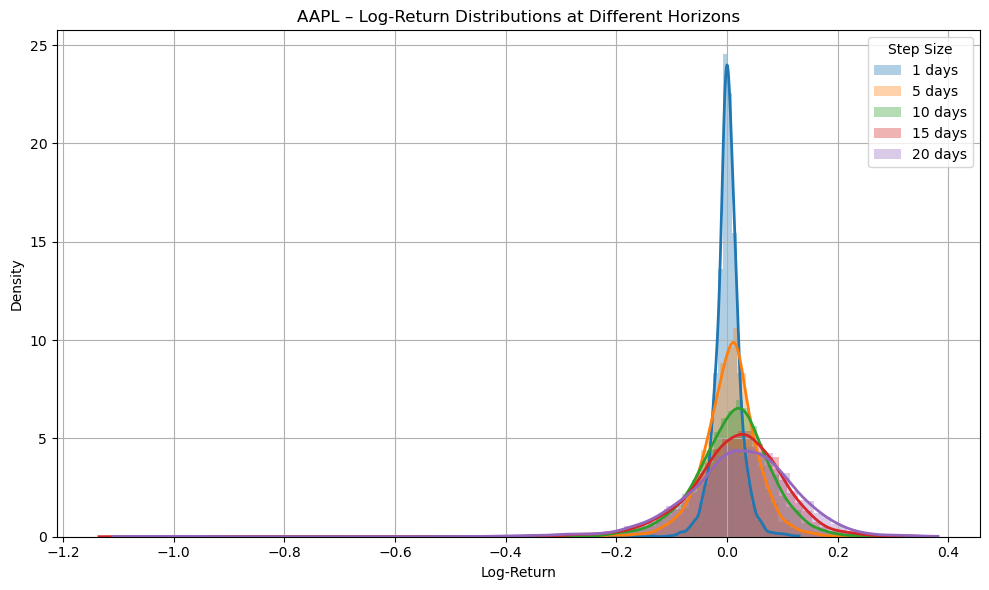

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


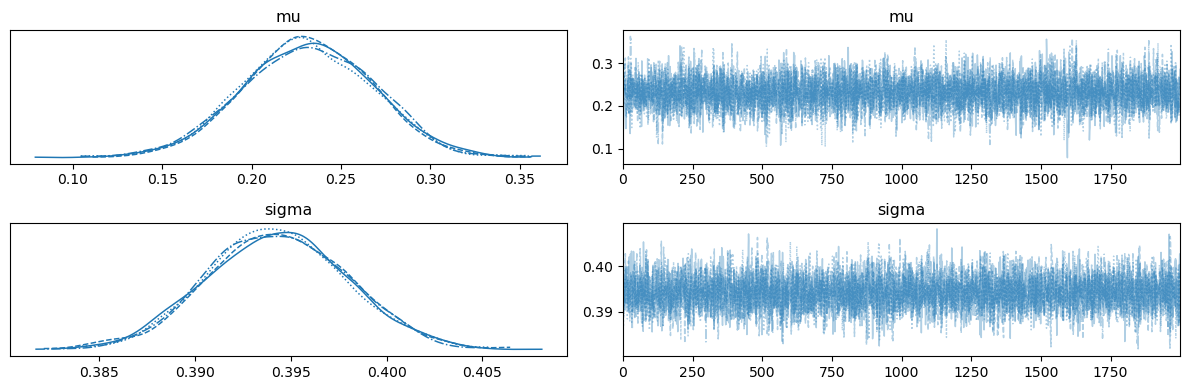

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations

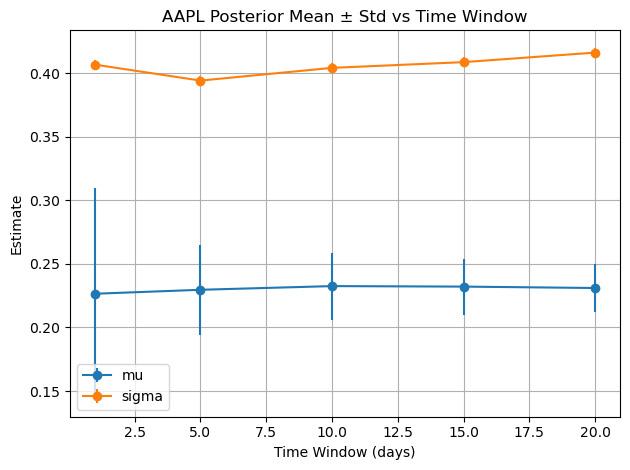

In [2]:
stock_name = "AAPL"
prices = GBM.yf.download(stock_name, start="2000-01-01", end="2023-12-31")["Close"].dropna()
time_window_list = [1, 5, 10, 15, 20]  # trading-day lags

GBM.plot_prices(prices, time_window_list, stock_name)
GBM.inference_gbm(prices, 5, plot =True)
GBM.inference_gbm_multi_time_scale(prices,time_window_list, stock_name)